# <font color='Blue'> Part 2: Deep Learning: Analysis of Chronic Kidney Disease Progression in Patients </font>

###### Chronic kidney disease,  or CKD, is a condition characterized by a gradual loss of kidney function over time. Early detection can help prevent the progression of kidney disease to kidney failure

For this task, you are given a set of longitudinal data (attached) of different lab measurements for patients diagnosed with chronic kidney disease (CKD). Furthermore, you are also given the information whether these patients progress in their CKD stage or not in the future. Using this dataset, you are required to come up with a solution to predict whether a patient will progress in CKD staging given the patient's past longitudinal information.

In [1]:
import  MyToolSet as my_internal_func


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### 1. Data Import

In [2]:
# Import data created during the processing stage of Part 1

dframe_demoalltestresults=pd.read_csv('output/dframe_demo_alltestresults.csv')


In [3]:
# The CKD-EPI (Chronic Kidney Disease Epidemiology Collaboration) equation was developed
# in an effort to create a more precise formula to estimate glomerular filtrate rate (GFR) from serum creatinine 
# and other readily available clinical parameters,


def eGFScore(row):
    k= 0.7 if row['gender']=='Female' else 0.9
    alpha=-0.329 if row['gender']=='Female' else -0.411
    f1=1.018 if row['gender']=='Female' else 1
    f2=1.159 if row['race']=='Black' else 1
    
    egfr=141* (min(row['Creatinine_mean']/k,1))**alpha * (max(row['Creatinine_mean']/k,1))**(-1.209)*  0.993**row['age']*f1*f2
    return round(egfr)
         
    
def CKD_stage(x):
    if x>=90: return 1
    elif 60<=x<=89: return 2
    elif 45<=x<=59: return 3
    elif 30<=x<=44 :return 3.5
    elif 15<=x<=29: return 4
    elif x<=15: return 5
    else: return 0


In [4]:

# Treat duplicate EHR records
dframe_demoalltestresults=dframe_demoalltestresults.groupby(['id','gender','CKD(t=0)','time'],as_index=False)[['Glucose','SBP','HGB','Lipoprotein']].mean()
dframe_demoalltestresults['rankscore']=dframe_demoalltestresults.sort_values(['id','time']).groupby(['id'],as_index=False)['time'].rank(ascending=False)

dframe_demoalltestresults=dframe_demoalltestresults.sort_values(['id','time'])[dframe_demoalltestresults.rankscore<15]


dframe_crossjoin1=pd.DataFrame(dframe_demoalltestresults["rankscore"].sort_values().unique())
dframe_crossjoin2=pd.DataFrame(dframe_demoalltestresults["id"].sort_values().unique())
print(dframe_crossjoin1.shape)
print(dframe_crossjoin2.shape)
dframe_cros12=dframe_crossjoin2.merge(dframe_crossjoin1,how='cross')
dframe_cros12.columns=['id','rankscore']
print(dframe_cros12.head(5))

print(dframe_cros12.shape)

dframe_temporalData=dframe_demoalltestresults.merge(dframe_cros12,how='right',on=['id','rankscore'])
dframe_temporalData.update(dframe_temporalData.sort_values(['id','time']).groupby('id',as_index=False).ffill())

del(dframe_temporalData['time'])
dframe_temporalData.rename(columns={'rankscore':'Time Window'},inplace=True)
dframe_smoothened_temporal=dframe_temporalData
dframe_temporalData.head()


(14, 1)
(300, 1)
   id  rankscore
0   0        1.0
1   0        2.0
2   0        3.0
3   0        4.0
4   0        5.0
(4200, 2)


,id,gender,CKD(t=0),Glucose,SBP,HGB,Lipoprotein,Time Window
0,0,Male,0.0,5.78,147.5,13.13,157.9,1.0
1,0,Male,0.0,5.78,147.5,13.65,157.9,2.0
2,0,Male,0.0,5.78,147.5,12.63,157.9,3.0
3,0,Male,0.0,5.78,147.5,13.36,157.9,4.0
4,0,Male,0.0,5.78,147.5,13.53,157.9,5.0


In [5]:
from sklearn.preprocessing import StandardScaler
dframe_container=pd.DataFrame()
dframe_container['id']=dframe_temporalData['id'].unique()

scaler=StandardScaler()        
    
for col in ['Glucose','HGB','SBP','Lipoprotein']:
    dframe_smoothened_temporal[col]=scaler.fit_transform(dframe_smoothened_temporal[col].values.astype(float).reshape(-1, 1))
    dframe_temp=pd.pivot_table(dframe_smoothened_temporal,
                               index=['id'],
                               columns='Time Window',
                               values=col,
                               aggfunc=max)
    orig_col=dframe_temp.columns
    new_col=[ col+"_"+str(x) for x in orig_col]
    dframe_temp.columns=new_col
    dframe_temp=dframe_temp.reset_index()
    
    dframe_container=dframe_container.merge(dframe_temp,how='left',on='id')
print(dframe_container.shape)    
dframe_container=pd.read_csv('Output/Prediction_Ready.csv')[['id','gender','CKD(t=0)']].merge(dframe_container,on='id',how='inner')
dframe_container=dframe_container.merge(pd.read_csv('T_Stage.csv')[['id','target']],on='id',how='inner')
dframe_container['gender']=dframe_container['gender'].apply(lambda x: 1 if x=="Male" else 0)
# dframe_container=dframe_container.set_index('id')
dframe_container
    

(300, 57)


,id,gender,CKD(t=0),Glucose_1.0,Glucose_2.0,Glucose_3.0,Glucose_4.0,Glucose_5.0,Glucose_6.0,Glucose_7.0,...,Lipoprotein_6.0,Lipoprotein_7.0,Lipoprotein_8.0,Lipoprotein_9.0,Lipoprotein_10.0,Lipoprotein_11.0,Lipoprotein_12.0,Lipoprotein_13.0,Lipoprotein_14.0,target
0,0,1,3.0,-0.564285,-0.564285,-0.564285,-0.564285,-0.564285,-0.663496,-0.663496,...,2.556857,2.556857,2.556857,2.556857,2.556857,0.890310,0.890310,0.890310,0.890310,1
1,1,0,4.0,1.915973,1.915973,1.915973,1.915973,1.915973,1.915973,1.915973,...,-0.476681,-0.476681,-0.269572,-0.269572,-0.269572,-0.536878,-0.536878,-0.536878,0.436677,0
2,2,0,4.0,0.216996,0.216996,0.216996,0.216996,0.216996,-0.973528,-0.973528,...,0.021384,0.021384,-0.338727,-0.338727,-0.338727,-0.338727,-0.893048,-0.893048,0.021384,1
3,3,1,1.0,-0.570486,-0.570486,-0.570486,-0.570486,-0.570486,-0.570486,-0.570486,...,0.533065,0.533065,0.533065,0.533065,0.533065,-0.205791,-0.205791,-0.205791,0.850895,0
4,4,0,3.0,2.672452,2.672452,2.672452,2.672452,2.672452,1.946977,1.946977,...,-0.520037,-0.520037,-1.144231,-1.144231,-1.144231,-1.144231,-0.547628,-0.547628,-0.547628,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0,4.0,-0.520881,-0.520881,-0.520881,-0.520881,-0.266654,-0.266654,-0.961127,...,0.746266,0.746266,0.746266,0.746266,0.746266,0.746266,0.746266,1.252930,1.252930,1
296,296,0,4.0,0.725449,0.725449,0.725449,0.725449,0.725449,0.725449,0.725449,...,0.189078,0.189078,0.607954,0.607954,1.483688,1.483688,1.483688,0.162921,0.162921,0
297,297,1,3.0,1.791960,1.791960,1.791960,1.791960,1.791960,0.756452,0.756452,...,0.805030,0.805030,1.547111,1.547111,1.547111,1.547111,1.504829,1.504829,1.504829,1
298,298,0,3.0,-0.440273,-0.440273,-0.440273,-0.837114,-0.837114,-0.837114,-0.781308,...,-0.356643,0.597205,0.597205,0.597205,0.597205,0.597205,0.597205,0.597205,-0.613200,0


In [6]:
# Scaling of data
dframe_temporal_final=dframe_container
# dframe_temporal_final=my_internal_func.my_preprocess(dframe_container,'standard',ignore=['id','target','CKD(t=0)'])
dframe_temporal_final.to_csv('output/dframe_temporal_final.csv',index=False)
dframe_temporal_final

,id,gender,CKD(t=0),Glucose_1.0,Glucose_2.0,Glucose_3.0,Glucose_4.0,Glucose_5.0,Glucose_6.0,Glucose_7.0,...,Lipoprotein_6.0,Lipoprotein_7.0,Lipoprotein_8.0,Lipoprotein_9.0,Lipoprotein_10.0,Lipoprotein_11.0,Lipoprotein_12.0,Lipoprotein_13.0,Lipoprotein_14.0,target
0,0,1,3.0,-0.564285,-0.564285,-0.564285,-0.564285,-0.564285,-0.663496,-0.663496,...,2.556857,2.556857,2.556857,2.556857,2.556857,0.890310,0.890310,0.890310,0.890310,1
1,1,0,4.0,1.915973,1.915973,1.915973,1.915973,1.915973,1.915973,1.915973,...,-0.476681,-0.476681,-0.269572,-0.269572,-0.269572,-0.536878,-0.536878,-0.536878,0.436677,0
2,2,0,4.0,0.216996,0.216996,0.216996,0.216996,0.216996,-0.973528,-0.973528,...,0.021384,0.021384,-0.338727,-0.338727,-0.338727,-0.338727,-0.893048,-0.893048,0.021384,1
3,3,1,1.0,-0.570486,-0.570486,-0.570486,-0.570486,-0.570486,-0.570486,-0.570486,...,0.533065,0.533065,0.533065,0.533065,0.533065,-0.205791,-0.205791,-0.205791,0.850895,0
4,4,0,3.0,2.672452,2.672452,2.672452,2.672452,2.672452,1.946977,1.946977,...,-0.520037,-0.520037,-1.144231,-1.144231,-1.144231,-1.144231,-0.547628,-0.547628,-0.547628,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0,4.0,-0.520881,-0.520881,-0.520881,-0.520881,-0.266654,-0.266654,-0.961127,...,0.746266,0.746266,0.746266,0.746266,0.746266,0.746266,0.746266,1.252930,1.252930,1
296,296,0,4.0,0.725449,0.725449,0.725449,0.725449,0.725449,0.725449,0.725449,...,0.189078,0.189078,0.607954,0.607954,1.483688,1.483688,1.483688,0.162921,0.162921,0
297,297,1,3.0,1.791960,1.791960,1.791960,1.791960,1.791960,0.756452,0.756452,...,0.805030,0.805030,1.547111,1.547111,1.547111,1.547111,1.504829,1.504829,1.504829,1
298,298,0,3.0,-0.440273,-0.440273,-0.440273,-0.837114,-0.837114,-0.837114,-0.781308,...,-0.356643,0.597205,0.597205,0.597205,0.597205,0.597205,0.597205,0.597205,-0.613200,0


In [7]:


# dframe_temporal_final=my_internal_func.my_BalancedSample(dframe_temporal_final,'target',choice=2)
# dframe_temporal_final

#### <font color='grey'> Advanced Approach(Deep Learning)</font>

The recall value of the linear model(s) are quite poor. Let us try to improve it using the identified features but with the longitudinal data nature intact. We will build a RNN. But before that we need to standardise the observation period across patients to some extent. By visual inspection of the file 'Window.csv' produced by the code we can come to a cutoff period.

In [8]:
# Train Test split with imbalanced restored.

minority_id=dframe_temporal_final[dframe_temporal_final.target==1]['id'].unique()
majority_id=dframe_temporal_final[dframe_temporal_final.target==0]['id'].unique()
len(minority_id)

minority_test_id=pd.Series(minority_id).sample(frac=0.10,random_state=0)
majority_test_id=pd.Series(majority_id).sample(frac=0.50,random_state=0)

dframe_test=dframe_temporal_final[dframe_temporal_final.id.isin(minority_test_id) | dframe_temporal_final.id.isin(majority_test_id)]
dframe_train=dframe_temporal_final[~dframe_temporal_final.id.isin(dframe_test.id)]

# SMOTEE method for class balancing 
dframe_train=my_internal_func.my_BalancedSample(dframe_train,'target',choice=1)
print(dframe_train.shape,dframe_test.shape)


dframe_train_X_time=dframe_train.filter(like="_")
dframe_train_static=dframe_train[['gender','CKD(t=0)']]
dframe_train_Y=dframe_train['target']
print(dframe_train_X_time.shape)

dframe_test_X_time=dframe_test.filter(like="_")
dframe_test_static=dframe_test[['gender','CKD(t=0)']]
dframe_test_Y=dframe_test['target']
print(dframe_test_X_time.shape)

dframe_train_X_time


the data originally has a shape--------->
 0    100
1     90
Name: target, dtype: int64

the data now has a shape------->
 0    80
1    80
Name: target, dtype: int64
(160, 60) (110, 60)
(160, 56)
(110, 56)


,Glucose_1.0,Glucose_10.0,Glucose_11.0,Glucose_12.0,Glucose_13.0,Glucose_14.0,Glucose_2.0,Glucose_3.0,Glucose_4.0,Glucose_5.0,...,SBP_13.0,SBP_14.0,SBP_2.0,SBP_3.0,SBP_4.0,SBP_5.0,SBP_6.0,SBP_7.0,SBP_8.0,SBP_9.0
0,1.915973,1.903572,1.078886,1.078886,1.078886,0.979676,1.915973,1.915973,1.915973,1.915973,...,0.292638,0.292638,1.103895,1.103895,1.103895,1.103895,1.519400,0.764679,0.764679,0.764679
1,0.216996,-0.973528,-0.973528,-0.973528,0.341009,0.216996,0.216996,0.216996,0.216996,0.216996,...,-0.038404,0.204769,0.204769,0.204769,0.204769,0.974475,0.974475,0.974475,0.974475,0.699970
2,-0.012428,1.345514,1.345514,1.345514,0.508426,0.508426,-0.012428,-0.012428,-0.012428,-0.012428,...,0.323971,0.323971,1.074605,1.074605,1.074605,-0.972268,-0.972268,-0.972268,-0.972268,-0.726371
3,-0.725502,-0.595289,-0.632493,-0.632493,-0.713101,-0.713101,-0.725502,-0.725502,-0.725502,-0.725502,...,2.605163,2.605163,0.930200,0.930200,0.930200,0.930200,1.150895,2.051383,2.051383,2.051383
4,1.618342,1.618342,2.331417,2.331417,2.331417,2.331417,1.618342,1.618342,1.618342,1.618342,...,1.996209,1.996209,1.867471,1.867471,1.867471,1.867471,1.867471,1.867471,1.867471,1.867471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,-0.399410,-0.398594,-0.264744,-0.264744,-0.270455,-0.270455,-0.399410,-0.399410,-0.399410,-0.399410,...,0.850436,1.696290,0.097864,0.097864,0.097864,0.097864,0.097864,0.097864,0.096827,0.096827
156,0.504186,0.310204,0.310204,0.521269,0.521269,0.733170,0.504186,0.504186,0.504186,0.563549,...,-1.385616,-0.949791,-0.382709,-0.382709,-0.382709,0.876844,0.876844,-0.122487,-0.122487,-0.151185
157,1.809913,0.818537,0.818537,1.140202,1.140202,1.614349,1.809913,0.898528,0.898528,0.898528,...,1.088370,1.088370,-0.026664,-0.026664,-0.026664,0.723729,0.723729,0.535272,-0.063963,0.142221
158,-0.205820,0.563996,0.563996,0.939202,0.939202,0.674063,-0.205820,-0.205820,-0.205820,-0.205820,...,-0.375235,-0.375235,-0.737837,-0.737837,-0.737837,-0.406816,-0.406816,-0.605847,-0.605847,-0.613390


### RNN with LSTM layer
References taken from the research paper :

Zhao J, Feng Q, Wu P, Lupu R, Wilke RA, Wells QS, Denny JC, Wei W-Q. Learning from Longitudinal Electronic Health Record and Genetic Data to Improve Cardiovascular Event Prediction. Scientific Reports. 2019; 9(1):717 doi:10.1038/s41598-018-36745-x

In [9]:
from keras.models import Sequential
# Import `Dense` from `keras.layers`
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model
import keras
import tensorflow


# tensorflow.random.set_seed(0)

In [10]:
# reshape input to be 3D [samples, timesteps, features]
dframe_train_X_time = dframe_train_X_time.to_numpy().reshape((dframe_train_X_time.shape[0], 14, 4))
dframe_test_X_time=dframe_test_X_time.to_numpy().reshape((dframe_test_X_time.shape[0], 14, 4))
dframe_train_X_time.shape

(160, 14, 4)

In [11]:
# Citation from 
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

main_input = Input(shape=(dframe_train_X_time.shape[1], dframe_train_X_time.shape[2]), name='main_input')

lstm_out = LSTM(16, dropout=0.25, recurrent_dropout=0.2)(main_input)

auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

auxiliary_input = Input(shape=(2,), name='aux_input')

x = keras.layers.concatenate([lstm_out, auxiliary_input])


x = Dense(4, activation='relu')(x)
x= Dropout(0.25)(x)



# And finally we add the main logistic regression layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)
#This defines a model with two inputs and two outputs:
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 14, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 16)           1344        ['main_input[0][0]']             
                                                                                                  
 aux_input (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 18)           0           ['lstm[0][0]',                   
                                                                  'aux_input[0][0]']          

In [13]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [14]:
model.compile(optimizer='adam',
              loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},loss_weights={'main_output': 1., 'aux_output': 0.10},
              metrics=['acc',recall_m])

In [15]:

# reduce_lr = ReduceLROnPlateau(monitor='val_main_output_loss', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
# checkpointer = ModelCheckpoint(filepath='lstm.hdf5', verbose=1, save_best_only=True)
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history=model.fit({'main_input': dframe_train_X_time.astype(np.float32), 'aux_input': dframe_train_static.astype(np.float32)},
          {'main_output':dframe_train_Y.astype(np.float32), 'aux_output': dframe_train_Y.astype(np.float32)},
          epochs=80 ,callbacks=[early_stopping],validation_split=0.05)

Epoch 1/80
5/5 [==============================] - 2s 95ms/step - loss: 0.7867 - main_output_loss: 0.7185 - aux_output_loss: 0.6817 - main_output_acc: 0.4934 - main_output_recall_m: 0.8036 - aux_output_acc: 0.5789 - aux_output_recall_m: 0.5263 - val_loss: 0.5804 - val_main_output_loss: 0.5111 - val_aux_output_loss: 0.6929 - val_main_output_acc: 1.0000 - val_main_output_recall_m: 1.0000 - val_aux_output_acc: 0.3750 - val_aux_output_recall_m: 0.3750
Epoch 2/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7944 - main_output_loss: 0.7266 - aux_output_loss: 0.6775 - main_output_acc: 0.5066 - main_output_recall_m: 0.7956 - aux_output_acc: 0.5987 - aux_output_recall_m: 0.5169 - val_loss: 0.6021 - val_main_output_loss: 0.5325 - val_aux_output_loss: 0.6963 - val_main_output_acc: 1.0000 - val_main_output_recall_m: 1.0000 - val_aux_output_acc: 0.3750 - val_aux_output_recall_m: 0.3750
Epoch 3/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7862 - main_output_loss: 

Epoch 9/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7556 - main_output_loss: 0.6875 - aux_output_loss: 0.6813 - main_output_acc: 0.5724 - main_output_recall_m: 0.6398 - aux_output_acc: 0.5855 - aux_output_recall_m: 0.4346 - val_loss: 0.7059 - val_main_output_loss: 0.6345 - val_aux_output_loss: 0.7145 - val_main_output_acc: 0.6250 - val_main_output_recall_m: 0.6250 - val_aux_output_acc: 0.3750 - val_aux_output_recall_m: 0.3750
Epoch 10/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7409 - main_output_loss: 0.6737 - aux_output_loss: 0.6721 - main_output_acc: 0.5987 - main_output_recall_m: 0.6940 - aux_output_acc: 0.6053 - aux_output_recall_m: 0.4942 - val_loss: 0.7120 - val_main_output_loss: 0.6405 - val_aux_output_loss: 0.7151 - val_main_output_acc: 0.6250 - val_main_output_recall_m: 0.6250 - val_aux_output_acc: 0.3750 - val_aux_output_recall_m: 0.3750
Epoch 11/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7482 - main_output_loss

Epoch 17/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7458 - main_output_loss: 0.6791 - aux_output_loss: 0.6669 - main_output_acc: 0.6316 - main_output_recall_m: 0.5850 - aux_output_acc: 0.6382 - aux_output_recall_m: 0.4956 - val_loss: 0.7337 - val_main_output_loss: 0.6620 - val_aux_output_loss: 0.7165 - val_main_output_acc: 0.6250 - val_main_output_recall_m: 0.6250 - val_aux_output_acc: 0.3750 - val_aux_output_recall_m: 0.3750
Epoch 18/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7363 - main_output_loss: 0.6694 - aux_output_loss: 0.6688 - main_output_acc: 0.6579 - main_output_recall_m: 0.5666 - aux_output_acc: 0.5921 - aux_output_recall_m: 0.4869 - val_loss: 0.7293 - val_main_output_loss: 0.6578 - val_aux_output_loss: 0.7144 - val_main_output_acc: 0.6250 - val_main_output_recall_m: 0.6250 - val_aux_output_acc: 0.3750 - val_aux_output_recall_m: 0.3750
Epoch 19/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7469 - main_output_los

Epoch 25/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7378 - main_output_loss: 0.6718 - aux_output_loss: 0.6601 - main_output_acc: 0.6118 - main_output_recall_m: 0.5957 - aux_output_acc: 0.5921 - aux_output_recall_m: 0.4985 - val_loss: 0.7187 - val_main_output_loss: 0.6482 - val_aux_output_loss: 0.7051 - val_main_output_acc: 0.6250 - val_main_output_recall_m: 0.6250 - val_aux_output_acc: 0.5000 - val_aux_output_recall_m: 0.5000
Epoch 26/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7287 - main_output_loss: 0.6627 - aux_output_loss: 0.6596 - main_output_acc: 0.6447 - main_output_recall_m: 0.6652 - aux_output_acc: 0.6184 - aux_output_recall_m: 0.5372 - val_loss: 0.7205 - val_main_output_loss: 0.6500 - val_aux_output_loss: 0.7048 - val_main_output_acc: 0.6250 - val_main_output_recall_m: 0.6250 - val_aux_output_acc: 0.5000 - val_aux_output_recall_m: 0.5000
Epoch 27/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7467 - main_output_los

Epoch 33/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7301 - main_output_loss: 0.6643 - aux_output_loss: 0.6580 - main_output_acc: 0.6053 - main_output_recall_m: 0.5667 - aux_output_acc: 0.5987 - aux_output_recall_m: 0.5111 - val_loss: 0.7229 - val_main_output_loss: 0.6531 - val_aux_output_loss: 0.6979 - val_main_output_acc: 0.7500 - val_main_output_recall_m: 0.7500 - val_aux_output_acc: 0.5000 - val_aux_output_recall_m: 0.5000
Epoch 34/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7407 - main_output_loss: 0.6754 - aux_output_loss: 0.6534 - main_output_acc: 0.6382 - main_output_recall_m: 0.5728 - aux_output_acc: 0.6118 - aux_output_recall_m: 0.5199 - val_loss: 0.7250 - val_main_output_loss: 0.6552 - val_aux_output_loss: 0.6978 - val_main_output_acc: 0.7500 - val_main_output_recall_m: 0.7500 - val_aux_output_acc: 0.5000 - val_aux_output_recall_m: 0.5000
Epoch 35/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7403 - main_output_los

Epoch 41/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7514 - main_output_loss: 0.6847 - aux_output_loss: 0.6663 - main_output_acc: 0.6316 - main_output_recall_m: 0.6097 - aux_output_acc: 0.6447 - aux_output_recall_m: 0.5707 - val_loss: 0.7168 - val_main_output_loss: 0.6480 - val_aux_output_loss: 0.6877 - val_main_output_acc: 0.7500 - val_main_output_recall_m: 0.7500 - val_aux_output_acc: 0.6250 - val_aux_output_recall_m: 0.6250
Epoch 42/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7171 - main_output_loss: 0.6519 - aux_output_loss: 0.6525 - main_output_acc: 0.6579 - main_output_recall_m: 0.6542 - aux_output_acc: 0.6447 - aux_output_recall_m: 0.5142 - val_loss: 0.7126 - val_main_output_loss: 0.6440 - val_aux_output_loss: 0.6851 - val_main_output_acc: 0.7500 - val_main_output_recall_m: 0.7500 - val_aux_output_acc: 0.6250 - val_aux_output_recall_m: 0.6250
Epoch 43/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7351 - main_output_los

Epoch 49/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7207 - main_output_loss: 0.6555 - aux_output_loss: 0.6512 - main_output_acc: 0.6711 - main_output_recall_m: 0.6764 - aux_output_acc: 0.6250 - aux_output_recall_m: 0.5376 - val_loss: 0.7032 - val_main_output_loss: 0.6360 - val_aux_output_loss: 0.6724 - val_main_output_acc: 0.5000 - val_main_output_recall_m: 0.5000 - val_aux_output_acc: 0.6250 - val_aux_output_recall_m: 0.6250
Epoch 50/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7075 - main_output_loss: 0.6437 - aux_output_loss: 0.6376 - main_output_acc: 0.6513 - main_output_recall_m: 0.7001 - aux_output_acc: 0.6776 - aux_output_recall_m: 0.6455 - val_loss: 0.6996 - val_main_output_loss: 0.6329 - val_aux_output_loss: 0.6667 - val_main_output_acc: 0.7500 - val_main_output_recall_m: 0.7500 - val_aux_output_acc: 0.6250 - val_aux_output_recall_m: 0.6250
Epoch 51/80
5/5 [==============================] - 0s 11ms/step - loss: 0.7281 - main_output_los

Epoch 57/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7030 - main_output_loss: 0.6394 - aux_output_loss: 0.6356 - main_output_acc: 0.6776 - main_output_recall_m: 0.6383 - aux_output_acc: 0.6513 - aux_output_recall_m: 0.5943 - val_loss: 0.7210 - val_main_output_loss: 0.6532 - val_aux_output_loss: 0.6779 - val_main_output_acc: 0.5000 - val_main_output_recall_m: 0.5000 - val_aux_output_acc: 0.6250 - val_aux_output_recall_m: 0.6250
Epoch 58/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7329 - main_output_loss: 0.6683 - aux_output_loss: 0.6463 - main_output_acc: 0.5921 - main_output_recall_m: 0.5180 - aux_output_acc: 0.6513 - aux_output_recall_m: 0.6346 - val_loss: 0.7197 - val_main_output_loss: 0.6523 - val_aux_output_loss: 0.6746 - val_main_output_acc: 0.5000 - val_main_output_recall_m: 0.5000 - val_aux_output_acc: 0.6250 - val_aux_output_recall_m: 0.6250
Epoch 59/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7229 - main_output_los

Epoch 65/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7014 - main_output_loss: 0.6375 - aux_output_loss: 0.6392 - main_output_acc: 0.6908 - main_output_recall_m: 0.6771 - aux_output_acc: 0.6776 - aux_output_recall_m: 0.6458 - val_loss: 0.6934 - val_main_output_loss: 0.6299 - val_aux_output_loss: 0.6357 - val_main_output_acc: 0.5000 - val_main_output_recall_m: 0.5000 - val_aux_output_acc: 0.7500 - val_aux_output_recall_m: 0.7500
Epoch 66/80
5/5 [==============================] - 0s 13ms/step - loss: 0.6986 - main_output_loss: 0.6351 - aux_output_loss: 0.6350 - main_output_acc: 0.6711 - main_output_recall_m: 0.6491 - aux_output_acc: 0.6382 - aux_output_recall_m: 0.5580 - val_loss: 0.6823 - val_main_output_loss: 0.6199 - val_aux_output_loss: 0.6246 - val_main_output_acc: 0.5000 - val_main_output_recall_m: 0.5000 - val_aux_output_acc: 0.7500 - val_aux_output_recall_m: 0.7500
Epoch 67/80
5/5 [==============================] - 0s 13ms/step - loss: 0.6995 - main_output_los

Epoch 73/80
5/5 [==============================] - 0s 13ms/step - loss: 0.6983 - main_output_loss: 0.6370 - aux_output_loss: 0.6134 - main_output_acc: 0.6908 - main_output_recall_m: 0.5671 - aux_output_acc: 0.6645 - aux_output_recall_m: 0.5652 - val_loss: 0.7213 - val_main_output_loss: 0.6554 - val_aux_output_loss: 0.6589 - val_main_output_acc: 0.5000 - val_main_output_recall_m: 0.5000 - val_aux_output_acc: 0.3750 - val_aux_output_recall_m: 0.3750
Epoch 74/80
5/5 [==============================] - 0s 13ms/step - loss: 0.6880 - main_output_loss: 0.6270 - aux_output_loss: 0.6107 - main_output_acc: 0.6974 - main_output_recall_m: 0.6237 - aux_output_acc: 0.6842 - aux_output_recall_m: 0.6069 - val_loss: 0.7153 - val_main_output_loss: 0.6502 - val_aux_output_loss: 0.6508 - val_main_output_acc: 0.5000 - val_main_output_recall_m: 0.5000 - val_aux_output_acc: 0.6250 - val_aux_output_recall_m: 0.6250
Epoch 75/80
5/5 [==============================] - 0s 13ms/step - loss: 0.7075 - main_output_los

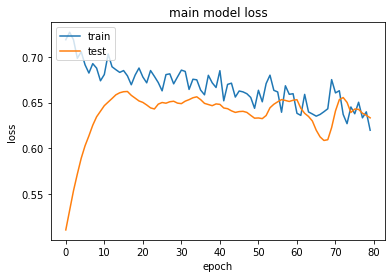

In [16]:

# summarize history for loss
plt.plot(history.history['main_output_loss'])
plt.plot(history.history['val_main_output_loss'])
plt.title('main model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [17]:
y_score = model.predict({'main_input': dframe_test_X_time.astype(np.float32), 'aux_input': dframe_test_static.astype(np.float32)})
y_pred = y_score

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
def compute_roc(y_test,y_score,method):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 2
    fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    # Compute micro-average ROC curve and ROC area
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=method+' (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

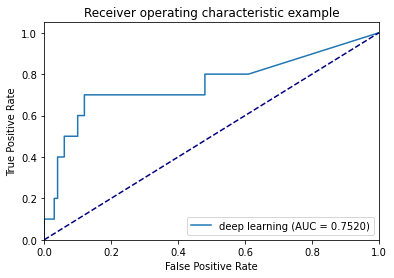

              precision    recall  f1-score   support

           0       0.95      0.60      0.74       100
           1       0.15      0.70      0.25        10

    accuracy                           0.61       110
   macro avg       0.55      0.65      0.49       110
weighted avg       0.88      0.61      0.69       110



In [19]:
# main auc
compute_roc(dframe_test_Y,y_score[0],'deep learning')
from sklearn.metrics import classification_report
print(classification_report(dframe_test_Y, (y_pred[0]>0.5).astype(int)))

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(dframe_train_X_time.shape[1], dframe_train_X_time.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add( Dense(1, activation='sigmoid', name='main_output'))
          
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(dframe_train_X_time.astype(np.float32), dframe_train_Y.astype(np.float32), epochs=100, class_weight={0:1,1:2.5})

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 64)            576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 main_output (Dense)         (None, 1)                 385       
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 4ms/step - loss: 1.0952
Epoch 2/100
5/5 [=============================

5/5 [==============================] - 0s 2ms/step - loss: 0.5843
Epoch 93/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5827
Epoch 94/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5786
Epoch 95/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5761
Epoch 96/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5730
Epoch 97/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5708
Epoch 98/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5668
Epoch 99/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5641
Epoch 100/100
5/5 [==============================] - 0s 2ms/step - loss: 0.5628


              precision    recall  f1-score   support

           0       0.95      0.35      0.51       100
           1       0.11      0.80      0.19        10

    accuracy                           0.39       110
   macro avg       0.53      0.57      0.35       110
weighted avg       0.87      0.39      0.48       110



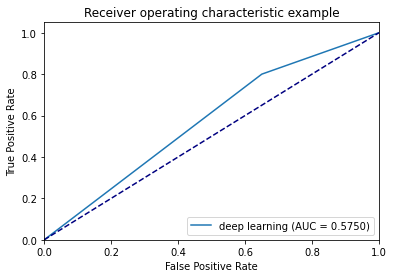

In [21]:
from sklearn.metrics import classification_report
y_pred=model.predict(dframe_test_X_time, verbose=0)
print(classification_report(dframe_test_Y, (y_pred>0.5).astype(int)))
compute_roc(dframe_test_Y,(y_pred>0.5).astype(int),'deep learning')

## Convulution Layer

In [22]:
from keras.layers import Convolution1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam,Nadam
from keras.layers import Dense, Flatten, Dropout,LeakyReLU
from keras.layers.noise import AlphaDropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.layers import Input,concatenate
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization




def create_network(time_steps, feature_size, aux_feature_size, filters=256, kernel_size=64,
                   learning_rate=0.0001,
                   aux_output_weight=0.5
                   ):
    """Generic function to create a fully-connected neural network.
    # Arguments
        n_dense: int > 0. Number of dense layers.
        dense_units: int > 0. Number of dense units per layer.
        dropout: keras.layers.Layer. A dropout layer to apply.
        dropout_rate: 0 <= float <= 1. The rate of dropout.
        kernel_initializer: str. The initializer for the weights.
        optimizer: str/keras.optimizers.Optimizer. The optimizer to use.
        max_words: int > 0. The maximum number of words per data point.
    # Returns
        A Keras model instance (compiled).
    """
    main_input = Input(shape=(time_steps, feature_size), name='main_input')
    x = Convolution1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(main_input)
    x = MaxPooling1D(pool_size=3)(x)
   
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(x)
    auxiliary_input = Input(shape=(aux_feature_size,), name='aux_input')
    x = concatenate([x, auxiliary_input])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation='relu')(x)
    # And finally we add the main logistic regression layer
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    # This defines a model with two inputs and two outputs:
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

    model.compile(optimizer=Nadam(learning_rate),
                  loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
                   metrics=['accuracy'])

    return model

In [23]:
model=create_network(dframe_train_X_time.shape[1],dframe_train_X_time.shape[2],2)

In [24]:
history=model.fit({'main_input': dframe_train_X_time.astype(np.float32), 'aux_input': dframe_train_static.astype(np.float32)},
          {'main_output':dframe_train_Y.astype(np.float32), 'aux_output': dframe_train_Y.astype(np.float32)},
          epochs=80 ,callbacks=[early_stopping],validation_split=0.10)

Epoch 1/80
5/5 [==============================] - 1s 50ms/step - loss: 1.6655 - main_output_loss: 0.8673 - aux_output_loss: 0.7982 - main_output_accuracy: 0.4861 - aux_output_accuracy: 0.5625 - val_loss: 1.3014 - val_main_output_loss: 0.6419 - val_aux_output_loss: 0.6595 - val_main_output_accuracy: 0.8125 - val_aux_output_accuracy: 0.8125
Epoch 2/80
5/5 [==============================] - 0s 12ms/step - loss: 1.4956 - main_output_loss: 0.8215 - aux_output_loss: 0.6741 - main_output_accuracy: 0.4861 - aux_output_accuracy: 0.6111 - val_loss: 1.2886 - val_main_output_loss: 0.6403 - val_aux_output_loss: 0.6483 - val_main_output_accuracy: 0.9375 - val_aux_output_accuracy: 0.8750
Epoch 3/80
5/5 [==============================] - 0s 12ms/step - loss: 1.4445 - main_output_loss: 0.7779 - aux_output_loss: 0.6666 - main_output_accuracy: 0.5208 - aux_output_accuracy: 0.6250 - val_loss: 1.2751 - val_main_output_loss: 0.6370 - val_aux_output_loss: 0.6381 - val_main_output_accuracy: 0.9375 - val_aux_o

5/5 [==============================] - 0s 12ms/step - loss: 1.0818 - main_output_loss: 0.5847 - aux_output_loss: 0.4971 - main_output_accuracy: 0.7014 - aux_output_accuracy: 0.7639 - val_loss: 1.2582 - val_main_output_loss: 0.6429 - val_aux_output_loss: 0.6153 - val_main_output_accuracy: 0.8125 - val_aux_output_accuracy: 0.8750
Epoch 12/80
5/5 [==============================] - 0s 12ms/step - loss: 1.0468 - main_output_loss: 0.5918 - aux_output_loss: 0.4550 - main_output_accuracy: 0.6736 - aux_output_accuracy: 0.7847 - val_loss: 1.2592 - val_main_output_loss: 0.6449 - val_aux_output_loss: 0.6144 - val_main_output_accuracy: 0.8125 - val_aux_output_accuracy: 0.8750
Epoch 13/80
5/5 [==============================] - 0s 11ms/step - loss: 1.1814 - main_output_loss: 0.6482 - aux_output_loss: 0.5332 - main_output_accuracy: 0.6806 - aux_output_accuracy: 0.7222 - val_loss: 1.2573 - val_main_output_loss: 0.6439 - val_aux_output_loss: 0.6133 - val_main_output_accuracy: 0.8125 - val_aux_output_acc

5/5 [==============================] - 0s 11ms/step - loss: 0.9775 - main_output_loss: 0.5555 - aux_output_loss: 0.4220 - main_output_accuracy: 0.7222 - aux_output_accuracy: 0.8333 - val_loss: 1.2383 - val_main_output_loss: 0.6426 - val_aux_output_loss: 0.5957 - val_main_output_accuracy: 0.8125 - val_aux_output_accuracy: 0.8750
Epoch 22/80
5/5 [==============================] - 0s 12ms/step - loss: 0.9655 - main_output_loss: 0.5424 - aux_output_loss: 0.4231 - main_output_accuracy: 0.7292 - aux_output_accuracy: 0.7778 - val_loss: 1.2331 - val_main_output_loss: 0.6397 - val_aux_output_loss: 0.5934 - val_main_output_accuracy: 0.8125 - val_aux_output_accuracy: 0.8750
Epoch 23/80
5/5 [==============================] - 0s 12ms/step - loss: 0.8608 - main_output_loss: 0.5027 - aux_output_loss: 0.3581 - main_output_accuracy: 0.7153 - aux_output_accuracy: 0.8542 - val_loss: 1.2252 - val_main_output_loss: 0.6379 - val_aux_output_loss: 0.5873 - val_main_output_accuracy: 0.8750 - val_aux_output_acc

5/5 [==============================] - 0s 16ms/step - loss: 0.8045 - main_output_loss: 0.4708 - aux_output_loss: 0.3337 - main_output_accuracy: 0.8194 - aux_output_accuracy: 0.8819 - val_loss: 1.1871 - val_main_output_loss: 0.6266 - val_aux_output_loss: 0.5605 - val_main_output_accuracy: 0.8125 - val_aux_output_accuracy: 0.8750
Epoch 32/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7670 - main_output_loss: 0.4377 - aux_output_loss: 0.3293 - main_output_accuracy: 0.7847 - aux_output_accuracy: 0.8611 - val_loss: 1.1804 - val_main_output_loss: 0.6219 - val_aux_output_loss: 0.5585 - val_main_output_accuracy: 0.8125 - val_aux_output_accuracy: 0.8750
Epoch 33/80
5/5 [==============================] - 0s 12ms/step - loss: 0.7399 - main_output_loss: 0.4407 - aux_output_loss: 0.2992 - main_output_accuracy: 0.7847 - aux_output_accuracy: 0.8819 - val_loss: 1.1690 - val_main_output_loss: 0.6171 - val_aux_output_loss: 0.5519 - val_main_output_accuracy: 0.8125 - val_aux_output_acc

5/5 [==============================] - 0s 12ms/step - loss: 0.7383 - main_output_loss: 0.4367 - aux_output_loss: 0.3016 - main_output_accuracy: 0.7639 - aux_output_accuracy: 0.8819 - val_loss: 1.1144 - val_main_output_loss: 0.5856 - val_aux_output_loss: 0.5288 - val_main_output_accuracy: 0.8750 - val_aux_output_accuracy: 0.8750
Epoch 42/80
5/5 [==============================] - 0s 12ms/step - loss: 0.6592 - main_output_loss: 0.3951 - aux_output_loss: 0.2641 - main_output_accuracy: 0.7986 - aux_output_accuracy: 0.9167 - val_loss: 1.1080 - val_main_output_loss: 0.5804 - val_aux_output_loss: 0.5276 - val_main_output_accuracy: 0.8750 - val_aux_output_accuracy: 0.8750
Epoch 43/80
5/5 [==============================] - 0s 12ms/step - loss: 0.7406 - main_output_loss: 0.4268 - aux_output_loss: 0.3138 - main_output_accuracy: 0.7986 - aux_output_accuracy: 0.8819 - val_loss: 1.0979 - val_main_output_loss: 0.5727 - val_aux_output_loss: 0.5252 - val_main_output_accuracy: 0.8750 - val_aux_output_acc

5/5 [==============================] - 0s 12ms/step - loss: 0.5914 - main_output_loss: 0.3557 - aux_output_loss: 0.2357 - main_output_accuracy: 0.8681 - aux_output_accuracy: 0.9444 - val_loss: 1.0218 - val_main_output_loss: 0.5260 - val_aux_output_loss: 0.4958 - val_main_output_accuracy: 0.8750 - val_aux_output_accuracy: 0.8750
Epoch 52/80
5/5 [==============================] - 0s 11ms/step - loss: 0.6014 - main_output_loss: 0.3510 - aux_output_loss: 0.2504 - main_output_accuracy: 0.8403 - aux_output_accuracy: 0.9097 - val_loss: 1.0128 - val_main_output_loss: 0.5217 - val_aux_output_loss: 0.4910 - val_main_output_accuracy: 0.8750 - val_aux_output_accuracy: 0.8750
Epoch 53/80
5/5 [==============================] - 0s 12ms/step - loss: 0.6049 - main_output_loss: 0.3661 - aux_output_loss: 0.2388 - main_output_accuracy: 0.8333 - aux_output_accuracy: 0.9028 - val_loss: 0.9975 - val_main_output_loss: 0.5144 - val_aux_output_loss: 0.4831 - val_main_output_accuracy: 0.8750 - val_aux_output_acc

5/5 [==============================] - 0s 12ms/step - loss: 0.4970 - main_output_loss: 0.2836 - aux_output_loss: 0.2134 - main_output_accuracy: 0.8889 - aux_output_accuracy: 0.9514 - val_loss: 0.9185 - val_main_output_loss: 0.4751 - val_aux_output_loss: 0.4434 - val_main_output_accuracy: 0.9375 - val_aux_output_accuracy: 0.8750
Epoch 62/80
5/5 [==============================] - 0s 13ms/step - loss: 0.4811 - main_output_loss: 0.2820 - aux_output_loss: 0.1991 - main_output_accuracy: 0.9236 - aux_output_accuracy: 0.9236 - val_loss: 0.9142 - val_main_output_loss: 0.4707 - val_aux_output_loss: 0.4435 - val_main_output_accuracy: 0.9375 - val_aux_output_accuracy: 0.8750
Epoch 63/80
5/5 [==============================] - 0s 12ms/step - loss: 0.5439 - main_output_loss: 0.3151 - aux_output_loss: 0.2288 - main_output_accuracy: 0.8611 - aux_output_accuracy: 0.9444 - val_loss: 0.8998 - val_main_output_loss: 0.4590 - val_aux_output_loss: 0.4408 - val_main_output_accuracy: 0.9375 - val_aux_output_acc

5/5 [==============================] - 0s 14ms/step - loss: 0.4550 - main_output_loss: 0.2583 - aux_output_loss: 0.1967 - main_output_accuracy: 0.9167 - aux_output_accuracy: 0.9097 - val_loss: 0.7979 - val_main_output_loss: 0.4034 - val_aux_output_loss: 0.3945 - val_main_output_accuracy: 0.9375 - val_aux_output_accuracy: 0.9375
Epoch 72/80
5/5 [==============================] - 0s 11ms/step - loss: 0.4452 - main_output_loss: 0.2778 - aux_output_loss: 0.1674 - main_output_accuracy: 0.8889 - aux_output_accuracy: 0.9583 - val_loss: 0.7792 - val_main_output_loss: 0.3927 - val_aux_output_loss: 0.3865 - val_main_output_accuracy: 0.9375 - val_aux_output_accuracy: 0.9375
Epoch 73/80
5/5 [==============================] - 0s 12ms/step - loss: 0.4856 - main_output_loss: 0.2881 - aux_output_loss: 0.1975 - main_output_accuracy: 0.8750 - aux_output_accuracy: 0.9236 - val_loss: 0.7819 - val_main_output_loss: 0.3910 - val_aux_output_loss: 0.3909 - val_main_output_accuracy: 0.9375 - val_aux_output_acc

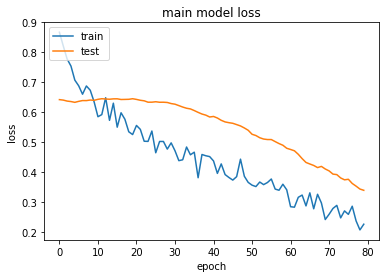

In [25]:
# summarize history for loss
plt.plot(history.history['main_output_loss'])
plt.plot(history.history['val_main_output_loss'])
plt.title('main model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


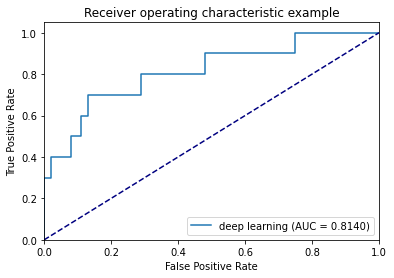

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       100
           1       0.24      0.70      0.36        10

    accuracy                           0.77       110
   macro avg       0.60      0.74      0.61       110
weighted avg       0.90      0.77      0.82       110



In [26]:
y_score = model.predict({'main_input': dframe_test_X_time.astype(np.float32), 'aux_input': dframe_test_static.astype(np.float32)})
y_pred = y_score

from sklearn.metrics import roc_curve, auc
from sklearn import metrics
def compute_roc(y_test,y_score,method):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 2
    fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    # Compute micro-average ROC curve and ROC area
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=method+' (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    
    # main auc
compute_roc(dframe_test_Y,y_score[0],'deep learning')
from sklearn.metrics import classification_report
print(classification_report(dframe_test_Y, (y_pred[0]>0.5).astype(int)))